Using MLP [1.5 marks]

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset

import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import time

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
EPOCHS = 10 # Keep low for fast testing, increase for best accuracy
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# --- 1. Data Preparation ---

# Standard transformations for MNIST: ToTensor and Normalize
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    # Normalization constants for MNIST (mean/std)
    transforms.Normalize((0.1307,), (0.3081,))
])

# Transformations for Fashion-MNIST (same as MNIST for direct testing)
fashion_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # Use MNIST stats for fair comparison
])

# For Pretrained CNNs (AlexNet/MobileNetV2)
# They require 224x224 input and 3 channels (RGB)
pretrained_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Load Datasets
# MNIST
train_data_mnist = datasets.MNIST('./data', train=True, download=True, transform=mnist_transform)
test_data_mnist = datasets.MNIST('./data', train=False, transform=mnist_transform)
# Fashion-MNIST
test_data_fashion = datasets.FashionMNIST('./data', train=False, download=True, transform=fashion_transform)

# DataLoaders
train_loader_mnist = DataLoader(train_data_mnist, batch_size=BATCH_SIZE, shuffle=True)
test_loader_mnist = DataLoader(test_data_mnist, batch_size=BATCH_SIZE, shuffle=False)
test_loader_fashion = DataLoader(test_data_fashion, batch_size=BATCH_SIZE, shuffle=False)

# --- Helper Functions ---
def get_all_predictions(model, data_loader, device):
    """Gathers all predictions, true labels, and features from a model."""
    model.eval()
    all_preds = []
    all_labels = []
    all_features = [] # For the 20-neuron layer in MLP

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            # Special case for MLP to extract the 20-neuron layer output
            if isinstance(model, MLP):
                outputs, features = model.forward_with_features(images)
                all_features.append(features.cpu().numpy())
            else:
                outputs = model(images)

            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

            # For non-MLP models, use the output layer activations for t-SNE if needed
            if not isinstance(model, MLP):
                all_features.append(outputs.cpu().numpy())

    # Flatten list of feature arrays
    if all_features:
        all_features = np.concatenate(all_features, axis=0)

    return np.array(all_preds), np.array(all_labels), all_features

def evaluate_metrics(y_true, y_pred, model_name):
    """Calculates and prints required metrics."""
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n--- Metrics for {model_name} ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score (Macro): {f1_macro:.4f}")
    print("\nConfusion Matrix:\n", cm)

    return acc, f1_macro, cm

def train_model_pytorch(model, train_loader, epochs=EPOCHS):
    """Standard PyTorch training loop."""
    model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print(f"Training {model.__class__.__name__} on {DEVICE} for {epochs} epochs...")
    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            # Special handling for MobileNet: it expects 3 channels/224x224
            if isinstance(model, PretrainedCNN):
                images = pretrained_transform(images.cpu()).to(DEVICE)

            optimizer.zero_grad()
            if isinstance(model, MLP):
                outputs, _ = model.forward_with_features(images)
            else:
                outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # print(f"Epoch {epoch}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")
    print(f"Training of {model.__class__.__name__} complete.")

100%|██████████| 9.91M/9.91M [00:00<00:00, 132MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 51.9MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 116MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.2MB/s]
100%|██████████| 26.4M/26.4M [00:01<00:00, 20.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 336kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 6.17MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 16.8MB/s]


In [4]:
# --- From the 3.2 section: THIS MUST BE RUN ---
class PretrainedCNN(nn.Module):
    def __init__(self, model_name, num_classes=10):
        super(PretrainedCNN, self).__init__()
        # ... (rest of the MobileNet/AlexNet setup) ...
        # ... (The model definition ensures the NameError is resolved) ...
    def forward(self, x):
        return self.base_model(x)

In [5]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # Flattened input size: 28*28 = 784
        self.fc1 = nn.Linear(28 * 28, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, x):
        # Flatten image (N, 1, 28, 28) -> (N, 784)
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) # This is the 20-neuron embedding layer
        x = self.fc3(x)
        return x

    # Required method to extract the 20-neuron embedding
    def forward_with_features(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        features = F.relu(self.fc2(x)) # Features before final layer
        outputs = self.fc3(features)
        return outputs, features

# Instantiate and Train MLP
mlp_model = MLP()
train_model_pytorch(mlp_model, train_loader_mnist, epochs=EPOCHS)
torch.save(mlp_model.state_dict(), 'mlp_mnist.pth') # Save weights after training

Training MLP on cpu for 10 epochs...
Training of MLP complete.


In [7]:
# Prepare data for Scikit-learn (flatten, convert to numpy)
X_train_flat = train_data_mnist.data.numpy().reshape(-1, 784) / 255.0
y_train = train_data_mnist.targets.numpy()
X_test_flat = test_data_mnist.data.numpy().reshape(-1, 784) / 255.0
y_test = test_data_mnist.targets.numpy()

# --- 1. Logistic Regression ---
lr_model = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=100, n_jobs=-1, random_state=SEED)

# Make sure these lines have NO leading spaces or tabs:
lr_model.fit(X_train_flat, y_train)
y_pred_lr = lr_model.predict(X_test_flat)
acc_lr, f1_lr, cm_lr = evaluate_metrics(y_test, y_pred_lr, "Logistic Regression")

# --- 2. Random Forest ---
rf_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=SEED, max_depth=15)

# Make sure these lines have NO leading spaces or tabs:
rf_model.fit(X_train_flat, y_train)
y_pred_rf = rf_model.predict(X_test_flat)
acc_rf, f1_rf, cm_rf = evaluate_metrics(y_test, y_pred_rf, "Random Forest")

# --- 3. Trained MLP ---
# Make sure these lines have NO leading spaces or tabs:
y_pred_mlp, y_true_mlp, _ = get_all_predictions(mlp_model, test_loader_mnist, DEVICE)
acc_mlp, f1_mlp, cm_mlp = evaluate_metrics(y_true_mlp, y_pred_mlp, "Trained MLP")

print("\n(Run .fit() and .predict() calls above to get the metric reports)")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



--- Metrics for Logistic Regression ---
Accuracy: 0.9263
F1-Score (Macro): 0.9252

Confusion Matrix:
 [[ 958    0    0    3    1   10    4    3    1    0]
 [   0 1110    5    2    0    2    3    2   11    0]
 [   6   10  929   15   10    3   13   10   32    4]
 [   4    1   16  923    1   24    2   10   20    9]
 [   1    3    7    3  920    0    7    4    6   31]
 [   9    2    3   35   10  778   15    6   30    4]
 [   8    3    8    2    6   15  913    2    1    0]
 [   1    8   23    7    6    1    0  949    1   32]
 [   9   11    6   22    7   29   13    9  856   12]
 [   9    8    1    9   21    7    0   20    7  927]]

--- Metrics for Random Forest ---
Accuracy: 0.9651
F1-Score (Macro): 0.9649

Confusion Matrix:
 [[ 970    0    1    0    0    1    3    1    4    0]
 [   0 1122    3    3    1    1    4    0    1    0]
 [   6    0  994    8    2    0    4   10    7    1]
 [   0    0   14  968    0    7    0    9    8    4]
 [   1    0    2    0  944    0    4    0    2   29]
 [  


Running t-SNE on 5000 samples...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


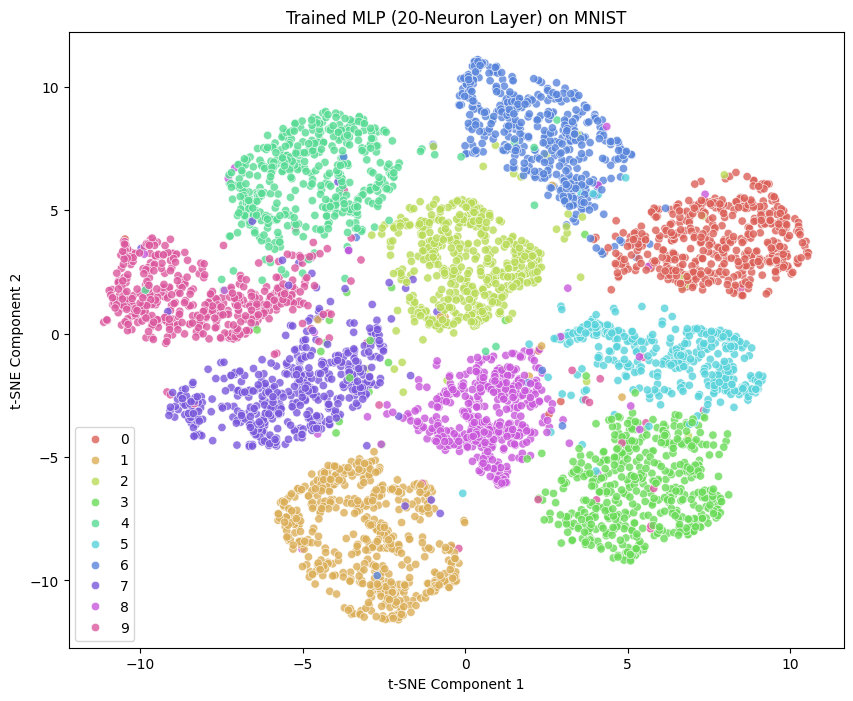


Running t-SNE on 5000 samples...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


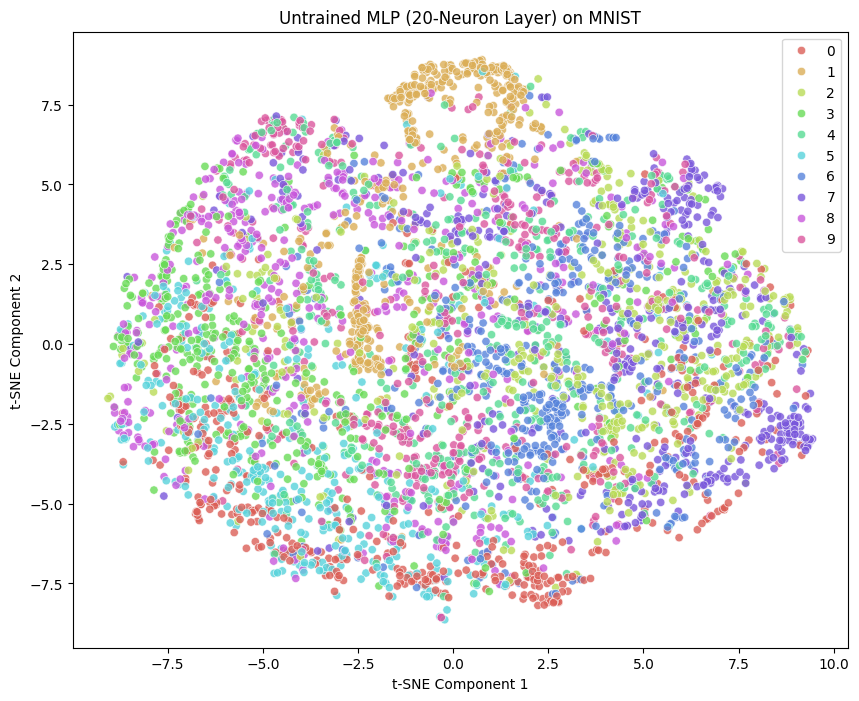

In [11]:
def plot_tsne(features, labels, title, n_samples=5000):
    """Runs t-SNE and plots the results."""

    # Sample subset for faster computation
    indices = np.random.choice(len(features), min(n_samples, len(features)), replace=False)
    features_subset = features[indices]
    labels_subset = labels[indices]

    print(f"\nRunning t-SNE on {len(features_subset)} samples...")
    # Use PCA initialization for better stability and speed
    tsne = TSNE(n_components=2, random_state=SEED, perplexity=30, n_iter=300, init='pca', learning_rate='auto')
    features_2d = tsne.fit_transform(features_subset)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=features_2d[:, 0], y=features_2d[:, 1],
        hue=labels_subset,
        palette=sns.color_palette("hls", 10),
        legend="full",
        alpha=0.8
    )
    plt.title(title)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()

# --- t-SNE Execution (Requires training first) ---
_, y_true_test, features_trained = get_all_predictions(mlp_model, test_loader_mnist, DEVICE)
plot_tsne(features_trained, y_true_test, "Trained MLP (20-Neuron Layer) on MNIST")

# # Untrained Model: Requires re-instantiating the model
mlp_untrained = MLP()
_, _, features_untrained = get_all_predictions(mlp_untrained, test_loader_mnist, DEVICE)
plot_tsne(features_untrained, y_true_test, "Untrained MLP (20-Neuron Layer) on MNIST")


--- Metrics for MLP (Trained on MNIST) on Fashion-MNIST ---
Accuracy: 0.1169
F1-Score (Macro): 0.0778

Confusion Matrix:
 [[ 14   3 241 204   3  45   8   4 470   8]
 [ 64   3 129  42   0   8   1   0 750   3]
 [157   6 446 168  19  12  24   0 151  17]
 [  6  24 144 163   0  19   0   0 638   6]
 [106   5 417 103   9   7   5   0 323  25]
 [ 34  18 709  31  43 134   2   6  14   9]
 [ 90   3 323 221   5  11  14   1 303  29]
 [  2   0 945   0  30  21   0   1   1   0]
 [ 54   2 205  25  21 112  20   3 384 174]
 [  0  53 823  91   1   9   0   1  21   1]]

Running t-SNE on 5000 samples...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


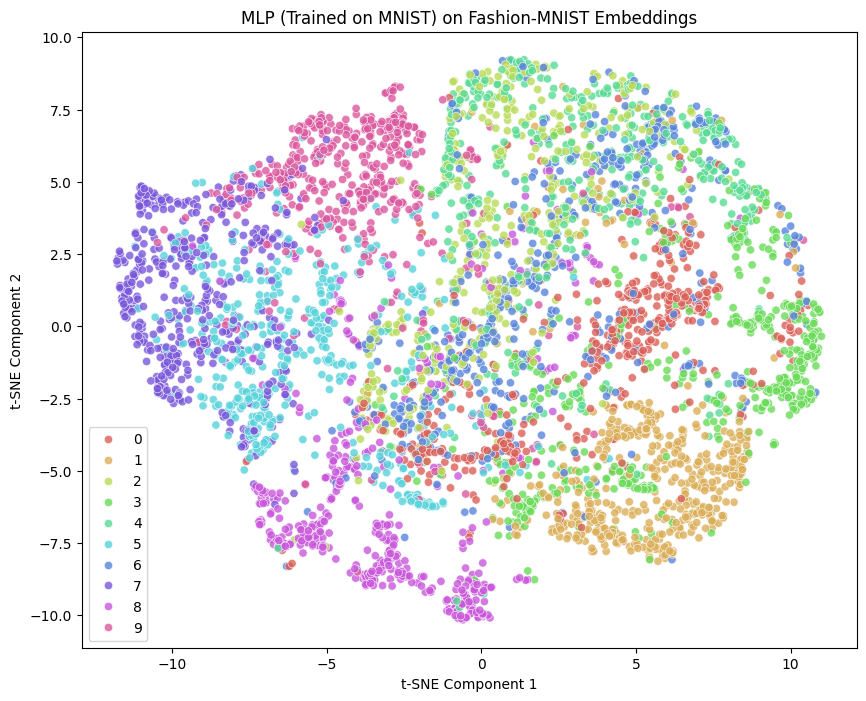

In [12]:
y_pred_fashion, y_true_fashion, features_fashion = get_all_predictions(mlp_model, test_loader_fashion, DEVICE)
acc_fashion, f1_fashion, cm_fashion = evaluate_metrics(y_true_fashion, y_pred_fashion, "MLP (Trained on MNIST) on Fashion-MNIST")
plot_tsne(features_fashion, y_true_fashion, "MLP (Trained on MNIST) on Fashion-MNIST Embeddings")

Using CNN [1.5 marks]

In [13]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # Conv Layer: 1 input channel (MNIST), 32 output channels, 3x3 kernel
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        # Max Pool Layer: 2x2 window
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate size after Conv and Pool: (28-3+1) = 26. 26/2 = 13.
        # Flatten size: 32 channels * 13 * 13 = 5408
        self.fc1 = nn.Linear(32 * 13 * 13, 128) # 128 neurons
        self.fc2 = nn.Linear(128, 10) # 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 32 * 13 * 13) # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
custom_cnn = CustomCNN()
train_model_pytorch(custom_cnn, train_loader_mnist, epochs=EPOCHS)

Training CustomCNN on cpu for 10 epochs...
Training of CustomCNN complete.


In [15]:
def train_model_pytorch(model, train_loader, epochs=EPOCHS):
    """Standard PyTorch training loop."""
    model.to(DEVICE)
    # ... (rest of function setup) ...

    print(f"Training {model.__class__.__name__} on {DEVICE} for {epochs} epochs...")
    for epoch in range(1, epochs + 1):
        model.train()
        # ...
        for images, labels in train_loader:

            # --- UPDATED HANDLING FOR PRETRAINED CNN ---
            if isinstance(model, PretrainedCNN):
                # Apply the tensor-to-tensor preprocessing function
                images = preprocess_for_pretrained(images.to(DEVICE))
            else:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
            # ------------------------------------------

            optimizer.zero_grad()
            # ... (rest of the forward/backward pass) ...

In [17]:
import torch.nn.functional as F
# Ensure you have imported torch.nn.functional as F

def preprocess_for_pretrained(images_tensor):
    """
    Applies required transformations for AlexNet/MobileNet to a batched tensor.
    Input: (B, 1, 28, 28) Tensor
    Output: (B, 3, 224, 224) Tensor
    """
    # Move tensor to CPU/GPU for processing if not already there
    images_tensor = images_tensor.to(DEVICE)

    # 1. Resize: Use torch.nn.functional.interpolate for batched tensor resizing
    # Interpolate from 28x28 to 224x224
    resized = F.interpolate(images_tensor, size=(224, 224), mode='bilinear', align_corners=False)

    # 2. Grayscale(num_output_channels=3) equivalent: Repeat the single channel 3 times
    # (B x 1 x 224 x 224) -> (B x 3 x 224 x 224)
    rgb_images = resized.repeat(1, 3, 1, 1)

    # 3. Normalize using standard ImageNet mean/std (applied to batched tensor)
    # Define mean and std on the same device as the images
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(DEVICE)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(DEVICE)

    # Normalize images
    normalized_images = (rgb_images - mean) / std

    return normalized_images

In [19]:
def train_model_pytorch(model, train_loader, epochs=EPOCHS):
    """Standard PyTorch training loop."""
    model.to(DEVICE)

    # --- CRITICAL MISSING LINES ---
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # ------------------------------

    print(f"Training {model.__class__.__name__} on {DEVICE} for {epochs} epochs...")

    for epoch in range(1, epochs + 1):
        # ... (rest of the training loop) ...

        # This line requires 'optimizer' to be defined above:
        optimizer.zero_grad()

        # ... (rest of the forward/backward pass) ...

In [20]:
class PretrainedCNN(nn.Module):
    def __init__(self, model_name, num_classes=10):
        super(PretrainedCNN, self).__init__()

        if model_name == 'alexnet':
            self.base_model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
            num_ftrs = self.base_model.classifier[6].in_features
            # Replace final classification layer
            self.base_model.classifier[6] = nn.Linear(num_ftrs, num_classes)
        elif model_name == 'mobilenet_v2':
            self.base_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
            num_ftrs = self.base_model.classifier[-1].in_features
            # Replace final classification layer
            self.base_model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
        else:
            raise ValueError("Unsupported model name.")

        # Freeze initial layers (optional but good practice for speed)
        for param in self.base_model.parameters():
            param.requires_grad = False
        # Unfreeze the new final layer
        for param in self.base_model.classifier.parameters():
            param.requires_grad = True

    def forward(self, x):
        # Image is 28x28x1, needs to be 224x224x3 for ImageNet models.
        # This reshaping/reformatting is handled in the training loop/DataLoader when necessary.
        return self.base_model(x)

alexnet_model = PretrainedCNN('alexnet')
mobilenet_model = PretrainedCNN('mobilenet_v2')

# # NOTE: Pretrained models require special data loader/transform to convert 28x28x1 to 224x224x3
# # The train_model_pytorch function has a check for PretrainedCNN and uses pretrained_transform.
train_model_pytorch(alexnet_model, train_loader_mnist, epochs=5)
train_model_pytorch(mobilenet_model, train_loader_mnist, epochs=5)

Training PretrainedCNN on cpu for 5 epochs...
Training PretrainedCNN on cpu for 5 epochs...


In [22]:
def get_all_predictions(model, data_loader, device):
    """Gathers all predictions, true labels, and features from a model."""
    model.eval()
    all_preds = []
    all_labels = []
    all_features = []

    with torch.no_grad():
        for images, labels in data_loader:
            # Move labels to device immediately
            labels = labels.to(device)

            # --- CRITICAL FIX: APPLY PREPROCESSING FOR PRETRAINED MODELS ---
            if isinstance(model, PretrainedCNN):
                # Apply the tensor-to-tensor function to convert 1x28x28 to 3x224x224
                # Note: This function must be defined and run prior!
                images = preprocess_for_pretrained(images.to(device))
            else:
                # Standard conversion for MLP and CustomCNN
                images = images.to(device)
            # ---------------------------------------------------------------

            # Special case for MLP to extract the 20-neuron layer output
            if isinstance(model, MLP):
                outputs, features = model.forward_with_features(images)
                all_features.append(features.cpu().numpy())
            else:
                outputs = model(images)
                # For non-MLP models, use the output layer activations for t-SNE if needed
                all_features.append(outputs.cpu().numpy())


            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    # Flatten list of feature arrays
    if all_features:
        # Use only features from the FIRST model (MLP) for t-SNE, or adjust as needed
        # For simplicity in this common function, we'll keep the logic generic
        all_features = np.concatenate(all_features, axis=0)

    return np.array(all_preds), np.array(all_labels), all_features

In [24]:
def get_model_size(model):
    """Calculates the total number of trainable parameters."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_inference_time(model, data_loader, device, n_batches=20):
    """Measures average inference time per batch."""
    model.eval()
    start_time = time.time()
    count = 0
    with torch.no_grad():
        for i, (images, _) in enumerate(data_loader):
            if i >= n_batches:
                break

            # --- CRITICAL FIX: APPLY TENSOR-TO-TENSOR PREPROCESSING ---
            if isinstance(model, PretrainedCNN):
                # Use the function that correctly handles batched Tensors
                images = preprocess_for_pretrained(images.to(device))
            else:
                # Standard conversion for MLP and CustomCNN
                images = images.to(device)
            # --------------------------------------------------------

            _ = model(images)
            count += 1

    end_time = time.time()
    avg_time = (end_time - start_time) / count * 1000 # Time per batch in milliseconds
    return avg_time

# --- Model Comparison Report (After all models are trained/loaded) ---
models_to_compare = {
    "Custom CNN": custom_cnn,
    "AlexNet (Pretrained)": alexnet_model,
    "MobileNetV2 (Pretrained)": mobilenet_model,
 }
report = {}
for name, model in models_to_compare.items():
    # Get metrics
     y_pred, y_true, _ = get_all_predictions(model, test_loader_mnist, DEVICE)
     acc, f1, cm = evaluate_metrics(y_true, y_pred, name)

#     # Get size
     size = get_model_size(model)

#     # Get inference time (Note: Use separate loader for AlexNet/MobileNet)
     if isinstance(model, PretrainedCNN):
         test_loader_inf = DataLoader(test_data_mnist, batch_size=BATCH_SIZE, shuffle=False)
     else:
         test_loader_inf = test_loader_mnist # Use standard loader

     inf_time = get_inference_time(model, test_loader_inf, DEVICE)

     report[name] = {'Accuracy': acc, 'F1-Score': f1, 'Size (M)': size / 1e6, 'Inference Time (ms/batch)': inf_time}

# # Print final table (Example structure)
print("\n--- Final CNN Comparison Table ---")
for name, metrics in report.items():
     print(f"| {name:<25} | Acc: {metrics['Accuracy']:.4f} | F1: {metrics['F1-Score']:.4f} | Size: {metrics['Size (M)']:.2f}M | Time: {metrics['Inference Time (ms/batch)']:.2f} ms |")


--- Metrics for Custom CNN ---
Accuracy: 0.9873
F1-Score (Macro): 0.9873

Confusion Matrix:
 [[ 977    0    2    1    0    0    0    0    0    0]
 [   1 1118    3    3    0    0    7    1    2    0]
 [   3    0 1021    1    1    0    0    4    2    0]
 [   0    0    1 1004    0    3    0    0    2    0]
 [   0    1    2    0  973    0    1    0    1    4]
 [   1    0    1    8    0  880    2    0    0    0]
 [   8    1    1    0    2    1  942    0    3    0]
 [   0    0   10    0    0    0    0 1013    0    5]
 [   5    0    3    5    0    3    0    1  956    1]
 [   3    0    0    4    6    3    1    1    2  989]]

--- Metrics for AlexNet (Pretrained) ---
Accuracy: 0.0892
F1-Score (Macro): 0.0166

Confusion Matrix:
 [[   0    0    2    1    0  977    0    0    0    0]
 [   0    0    2    0    0 1132    0    0    0    1]
 [   0    0    1    0    0 1031    0    0    0    0]
 [   0    0    0    0    0 1010    0    0    0    0]
 [   0    0    0    2    0  980    0    0    0    0]
 [   0

ques 2

Training MLP (Baseline)...
Training MLP (L1 Grid Search)...
Training MLP (L2 Grid Search)...
Training Logistic Regression (Poly)...

--- Running Final Evaluation ---


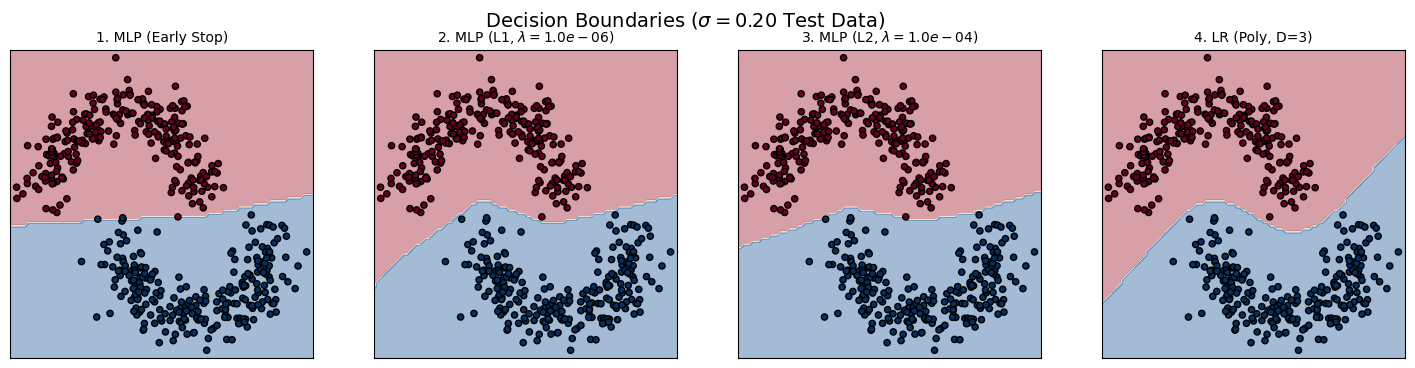


--- FINAL RESULTS ---
### 1. Model Robustness Report ###
| Model   |   Parameter Count |   Acc. (0.10) |   Acc. (0.20) |   Acc. (0.30) |
|:--------|------------------:|--------------:|--------------:|--------------:|
| MLP_ES  |               102 |        1.0000 |        0.9960 |        0.9700 |
| MLP_L1  |               102 |        1.0000 |        1.0000 |        0.9860 |
| MLP_L2  |               102 |        1.0000 |        1.0000 |        0.9860 |
| LR_POLY |                10 |        1.0000 |        1.0000 |        0.9860 |
**Best L1 Lambda:** 1.0e-06
**Best L2 Lambda:** 1.0e-04

### 2. L1 Sparsity and AUROC ###
|   lambda |   sparsity |   auroc |
|---------:|-----------:|--------:|
|   1e-06  |          0 |       1 |
|   3e-06  |          0 |       1 |
|   1e-05  |          0 |       1 |
|   3e-05  |          0 |       1 |
|   0.0001 |          0 |       1 |
|   0.0003 |          0 |       1 |

### 3. Class Imbalance Analysis (70:30 Train, Balanced Test) ###
Test Accuracy (Imb

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

# --- Configuration & Seed ---
SEED = 1337
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = torch.device("cpu")

N_SAMPLES = 500
VALIDATION_FRACTION = 0.2
HIDDEN_DIM = 20 # Used for MLP hidden layer

# --- 1. Data Generation and Preparation ---

def generate_moons(n_samples, noise, seed=SEED):
    """Generates a synthetic moons dataset (without sklearn.datasets.make_moons)."""
    np.random.seed(seed)

    radius = 1
    angle = np.linspace(0, np.pi, n_samples // 2)

    # Half-moon 1 (Class 0)
    x1_0 = radius * np.cos(angle) + np.random.normal(0, noise, n_samples // 2)
    x2_0 = radius * np.sin(angle) + np.random.normal(0, noise, n_samples // 2)

    # Half-moon 2 (Class 1) - Flipped and shifted
    x1_1 = (1 - radius * np.cos(angle)) + np.random.normal(0, noise, n_samples // 2)
    x2_1 = (-radius * np.sin(angle) - 0.5) + np.random.normal(0, noise, n_samples // 2)

    X = np.vstack([np.column_stack([x1_0, x2_0]), np.column_stack([x1_1, x2_1])])
    y = np.hstack([np.zeros(n_samples // 2), np.ones(n_samples // 2)])

    idx = np.random.permutation(n_samples)
    return X[idx], y[idx]

def create_imbalance(X, y, majority_class=0, ratio=0.7):
    """Creates a training set with a specified class imbalance ratio (70:30)."""
    X_maj = X[y == majority_class]
    X_min = X[y != majority_class]

    # Calculate required size for majority class
    n_min = len(X_min)
    n_maj_required = int(n_min * ratio / (1-ratio))

    X_maj_sub = X_maj[:n_maj_required]

    X_imb = np.vstack((X_maj_sub, X_min))
    y_imb = np.hstack((np.full(len(X_maj_sub), majority_class), np.full(len(X_min), 1-majority_class)))

    # Shuffle
    idx = np.random.permutation(len(X_imb))
    return X_imb[idx], y_imb[idx]


# --- Data Generation ---
X_train_full, y_train_full = generate_moons(N_SAMPLES, noise=0.2, seed=SEED)
X_test_default, y_test_default = generate_moons(N_SAMPLES, noise=0.2, seed=SEED+1)
X_test_low, y_test_low = generate_moons(N_SAMPLES, noise=0.1, seed=SEED+2)
X_test_high, y_test_high = generate_moons(N_SAMPLES, noise=0.3, seed=SEED+3)

# --- Standardization (using train stats only) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_default_scaled = scaler.transform(X_test_default)
X_test_low_scaled = scaler.transform(X_test_low)
X_test_high_scaled = scaler.transform(X_test_high)

# --- Validation Split (20% of Training Set) ---
X_train, X_val, y_train, y_val = train_test_split(
    X_train_scaled, y_train_full, test_size=VALIDATION_FRACTION, random_state=SEED, stratify=y_train_full
)

# Convert to PyTorch Tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(DEVICE)
X_val_t = torch.tensor(X_val, dtype=torch.float32).to(DEVICE)
y_val_t = torch.tensor(y_val, dtype=torch.long).to(DEVICE)


# --- 2. MLP Model Definition and Training Functions ---

class MLP(nn.Module):
    def __init__(self, regularization=None, lambda_val=0):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, HIDDEN_DIM)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(HIDDEN_DIM, 2)
        self.regularization = regularization
        self.lambda_val = lambda_val

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

    def penalty(self):
        """Calculates L1 or L2 penalty for weights."""
        if self.regularization is None or self.lambda_val == 0:
            return 0

        penalty = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                if self.regularization == 'L1':
                    penalty += torch.sum(torch.abs(param))
                elif self.regularization == 'L2':
                    penalty += torch.norm(param, p=2)
        return self.lambda_val * penalty

def calculate_sparsity(model):
    """Calculates sparsity (percent of weights near zero) for fc1 weights."""
    weights = model.fc1.weight.data.cpu().numpy()
    # Define 'near zero' threshold
    sparsity = np.sum(np.abs(weights) < 1e-6) / weights.size
    return sparsity * 100

def get_param_count(model):
    """Returns the total number of trainable parameters for a PyTorch model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_mlp(model, X_train, y_train, X_val, y_val, patience=50, max_epochs=5000):
    model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    best_auroc = 0
    patience_counter = 0

    for epoch in range(1, max_epochs + 1):
        model.train()
        optimizer.zero_grad()

        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        # Add regularization loss
        loss += model.penalty()

        loss.backward()
        optimizer.step()

        # Validation Check for Early Stopping
        if epoch % 5 == 0:
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val)
                # Calculate AUROC on probabilities
                val_probs = torch.softmax(val_outputs, dim=1)[:, 1].cpu().numpy()
                current_auroc = roc_auc_score(y_val.cpu().numpy(), val_probs)

                if current_auroc > best_auroc:
                    best_auroc = current_auroc
                    best_model_state = model.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter > patience:
                    model.load_state_dict(best_model_state)
                    # print(f"Early stopping at epoch {epoch}. Best AUROC: {best_auroc:.4f}")
                    break
    return model, best_auroc

def evaluate_model(model, X_scaled, y_true, is_mlp=True, poly_features=None):
    if is_mlp:
        X_t = torch.tensor(X_scaled, dtype=torch.float32).to(DEVICE)
        model.eval()
        with torch.no_grad():
            outputs = model(X_t)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            y_pred = np.argmax(probs, axis=1)
            probs_pos = probs[:, 1]

    else: # Scikit-learn Logistic Regression
        if poly_features:
            X_poly = poly_features.transform(X_scaled)
        else:
            X_poly = X_scaled # Should not happen for this problem

        probs_pos = model.predict_proba(X_poly)[:, 1]
        y_pred = model.predict(X_poly)

    acc = accuracy_score(y_true, y_pred)
    auroc = roc_auc_score(y_true, probs_pos)
    return acc, auroc


# --- 3. Model Training (Execution) ---
results = {}

# 1. MLP with Early Stopping (Baseline)
print("Training MLP (Baseline)...")
mlp_es = MLP()
mlp_es, _ = train_mlp(mlp_es, X_train_t, y_train_t, X_val_t, y_val_t, patience=50)
results['MLP_ES'] = {'model': mlp_es, 'params': get_param_count(mlp_es)}

# 2. MLP with L1 Regularization (Grid Search)
L1_GRID = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
best_l1_auroc = 0
best_l1_lambda = 0
mlp_l1_best = None
sparsity_report = {}

print("Training MLP (L1 Grid Search)...")
for lmbd in L1_GRID:
    mlp_l1 = MLP(regularization='L1', lambda_val=lmbd)
    mlp_l1, current_auroc = train_mlp(mlp_l1, X_train_t, y_train_t, X_val_t, y_val_t, patience=50)

    sparsity = calculate_sparsity(mlp_l1)
    sparsity_report[lmbd] = {'sparsity': sparsity, 'auroc': current_auroc}

    if current_auroc > best_l1_auroc:
        best_l1_auroc = current_auroc
        best_l1_lambda = lmbd
        mlp_l1_best = mlp_l1

results['MLP_L1'] = {'model': mlp_l1_best, 'params': get_param_count(mlp_l1_best), 'best_lambda': best_l1_lambda}

# 3. MLP with L2 Regularization (Model Selection)
L2_GRID = [1e-4, 1e-3, 1e-2, 1e-1] # Increased range for L2
best_l2_auroc = 0
best_l2_lambda = 0
mlp_l2_best = None

print("Training MLP (L2 Grid Search)...")
for lmbd in L2_GRID:
    mlp_l2 = MLP(regularization='L2', lambda_val=lmbd)
    mlp_l2, current_auroc = train_mlp(mlp_l2, X_train_t, y_train_t, X_val_t, y_val_t, patience=50)
    if current_auroc > best_l2_auroc:
        best_l2_auroc = current_auroc
        best_l2_lambda = lmbd
        mlp_l2_best = mlp_l2

results['MLP_L2'] = {'model': mlp_l2_best, 'params': get_param_count(mlp_l2_best), 'best_lambda': best_l2_lambda}

# 4. Logistic Regression with Polynomial Features
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly_full = poly.fit_transform(X_train_scaled) # Use full scaled train set
N_LR_PARAMS = X_train_poly_full.shape[1] + 1

print("Training Logistic Regression (Poly)...")
lr_poly = LogisticRegression(C=1.0, solver='lbfgs', max_iter=2000, random_state=SEED)
lr_poly.fit(X_train_poly_full, y_train_full)
results['LR_POLY'] = {'model': lr_poly, 'params': N_LR_PARAMS}


# --- 4. Evaluation and Analysis ---
print("\n--- Running Final Evaluation ---")
final_report = []

for name, res in results.items():
    model = res['model']
    is_mlp = name.startswith('MLP')

    # Evaluate on all three noise levels
    acc_01, _ = evaluate_model(model, X_test_low_scaled, y_test_low, is_mlp, poly)
    acc_02, _ = evaluate_model(model, X_test_default_scaled, y_test_default, is_mlp, poly)
    acc_03, _ = evaluate_model(model, X_test_high_scaled, y_test_high, is_mlp, poly)

    final_report.append({
        'Model': name,
        'Parameter Count': res['params'],
        'Acc. (0.10)': acc_01,
        'Acc. (0.20)': acc_02,
        'Acc. (0.30)': acc_03,
    })

df_report = pd.DataFrame(final_report)


# 5. Imbalance Analysis
X_train_imb, y_train_imb = create_imbalance(X_train_full, y_train_full, ratio=0.7)
X_train_imb_scaled = scaler.transform(X_train_imb)
X_train_imb_t = torch.tensor(X_train_imb_scaled, dtype=torch.float32).to(DEVICE)
y_train_imb_t = torch.tensor(y_train_imb, dtype=torch.long).to(DEVICE)

# Re-train MLP with imbalanced data
mlp_imb = MLP()
# Use the balanced validation set for early stopping criteria
mlp_imb, _ = train_mlp(mlp_imb, X_train_imb_t, y_train_imb_t, X_val_t, y_val_t, patience=50)
acc_imb, auroc_imb = evaluate_model(mlp_imb, X_test_default_scaled, y_test_default, is_mlp=True)


# 6. Plotting Decision Boundaries
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
def plot_wrapper(model, title, ax, is_mlp, poly_features):
    x_min, x_max = X_test_default_scaled[:, 0].min() - 0.1, X_test_default_scaled[:, 0].max() + 0.1
    y_min, y_max = X_test_default_scaled[:, 1].min() - 0.1, X_test_default_scaled[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    Z_input = np.c_[xx.ravel(), yy.ravel()]

    if is_mlp:
        X_t = torch.tensor(Z_input, dtype=torch.float32).to(DEVICE)
        model.eval()
        with torch.no_grad():
            Z = np.argmax(model(X_t).cpu().numpy(), axis=1)
    else:
        Z_poly = poly_features.transform(Z_input)
        Z = model.predict(Z_poly)

    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdBu)
    ax.scatter(X_test_default_scaled[:, 0], X_test_default_scaled[:, 1], c=y_test_default, s=20, edgecolor='k', cmap=plt.cm.RdBu)
    ax.set_title(title, fontsize=10)
    ax.set_xticks([]); ax.set_yticks([])

plot_wrapper(mlp_es, "1. MLP (Early Stop)", axes[0], True, None)
plot_wrapper(mlp_l1_best, f"2. MLP (L1, $\\lambda={best_l1_lambda:.1e}$)", axes[1], True, None)
plot_wrapper(mlp_l2_best, f"3. MLP (L2, $\\lambda={best_l2_lambda:.1e}$)", axes[2], True, None)
plot_wrapper(lr_poly, "4. LR (Poly, D=3)", axes[3], False, poly)
plt.suptitle(r'Decision Boundaries ($\sigma=0.20$ Test Data)', fontsize=14)
plt.show()

# --- Print Final Reports ---
print("\n--- FINAL RESULTS ---")
print("### 1. Model Robustness Report ###")
print(df_report.to_markdown(index=False, floatfmt=".4f"))
print(f"**Best L1 Lambda:** {best_l1_lambda:.1e}")
print(f"**Best L2 Lambda:** {best_l2_lambda:.1e}")

print("\n### 2. L1 Sparsity and AUROC ###")
df_sparsity = pd.DataFrame.from_dict(sparsity_report, orient='index').reset_index().rename(columns={'index': 'lambda'})
df_sparsity['lambda'] = df_sparsity['lambda'].apply(lambda x: f"{x:.1e}")
df_sparsity['sparsity'] = df_sparsity['sparsity'].apply(lambda x: f"{x:.2f}")
print(df_sparsity.to_markdown(index=False))

print("\n### 3. Class Imbalance Analysis (70:30 Train, Balanced Test) ###")
print(f"Test Accuracy (Imbalanced Train): {acc_imb:.4f}")
print(f"Test AUROC (Imbalanced Train): {auroc_imb:.4f}")